# MODELACIÓN EN HIDROLOGÍA
## Primer Parcial - Parte práctica (70%)

Su equipo de trabajo ha sido contratado para evaluar los efectos del cambio climático en el año 2050 sobre la disponibilidad de agua subterránea en una zona agrícola de Colombia. A continuación, se desarrolla un ejemplo muy simplificado de flujo de trabajo para cumplir con el objetivo del proyecto.

**Parte 1 - Corrección del sesgo con el método de mapeo de distribuciones (25 puntos)**

Usted cuenta con los siguientes archivos para las series de precipitación y temperatura promedio diarias simuladas con un modelo climático regional para el año 2050 en su área de estudio considerando una trayectoria de emisión de Gases Efecto Invernadero (GEI) particular:

- Precipitación: archivo *precip2050.csv*
- Temperatura: archivo *temp2050.csv*

La precipitación está en unidades de mm/d y la temperatura en K.

Un colega de su equipo de modelación le hace entrega de los parámetros de las distribuciones *gamma* y *normal* ajustadas para los datos simulados y observados de precipitación y temperatura durante el período de control:

**Parámetros distribución *gamma***

| Parámetro | Serie observada | Serie simulada |
| --------- | --------------- | -------------- |
| k         | 0.25            | 0.4            | 
| $\theta$  | 6.0             | 4.0            |

**Parámetros distribución *normal*** (valores en grados Celsius)

| Parámetro | Serie observada | Serie simulada |
| --------- | --------------- | -------------- |
| $\mu$     | 18.3            | 17.8           | 
| $\sigma$  | 2.2             | 2.9            |


**Nota:** En la práctica, es deseable tener los parámetros para cada mes. No obstante, para fines de este examen, se usará una sola distribución para todos los días del año.

Su primera tarea consiste en utilizar el método de mapeo de distribuciones para corregir el sesgo de las series simuladas en el año 2050. En el siguiente bloque usted ya cuenta con las funciones necesarias para llevar a cabo esta tarea. El procedimiento es el siguiente:

1. Importe los archivos con las series simuladas de precipitación y temperatura <br>
2. Para cada serie de datos, aplique el siguiente procedimiento: <br>
    a) Para cada valor simulado, use la función de probabilidad acumulada de los **datos simulados** y encuentre el valor de probabilidad acumulada respectivo. <br>
    b) Utilizando el valor obtenido en el paso a), utilice la función inversa de probabilidad acumulada de los **datos observados**. De esta forma encuentra el valor corregido. <br>

Recuerde, la distribución *gamma* se usa para la serie de **precipitación** y la distribución *normal* para la serie de **temperatura**. 

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt

def gamma_CFD(v, k, theta):
    return gamma.cdf(v, a=k, scale=theta)

def gamma_invCFD(perc, k, theta):
    return gamma.ppf(perc, a=k, scale=theta)

def normal_CFD(v, mu, sigma):
    return norm.cdf(v, loc=mu, scale=sigma)

def normal_invCFD(perc, mu, sigma):
    return norm.ppf(perc, loc=mu, scale=sigma)

Desarrolle en el siguiente bloque su código:

In [13]:
# Importar series simuladas de precipitación y temperatura

Psim = pd.read_csv('precip2050.csv')
Tsim = pd.read_csv('temp2050.csv')

# Mapeo de distribución para precipitación

values = Psim['value'] # Así se extraen los valores del DataFrame

# ---- programe aquí el método de mapeo de distribución ----------------------
new = []
for v in values:
    perc = gamma_CFD(v, 0.4, 4)
    corr = gamma_invCFD(perc, 0.25, 6)
    new = new + [corr]
# ----------------------------------------------------------------------------

Pcorr = Psim.copy() # Copie la serie original
Pcorr['value'] = new # Actualice los nuevos valores corregidos
    
# Mapeo de distribución para temperatura

# ---- programe aquí el método de mapeo de distribución ----------------------
values = Tsim['value']
new = []
for v in values:
    perc = normal_CFD(v - 273.15, 17.8, 2.9)
    corr = normal_invCFD(perc, 18.3, 2.2) + 273.15
    new = new + [corr]
    
Tcorr = Tsim.copy()
Tcorr['value'] = new
# ----------------------------------------------------------------------------

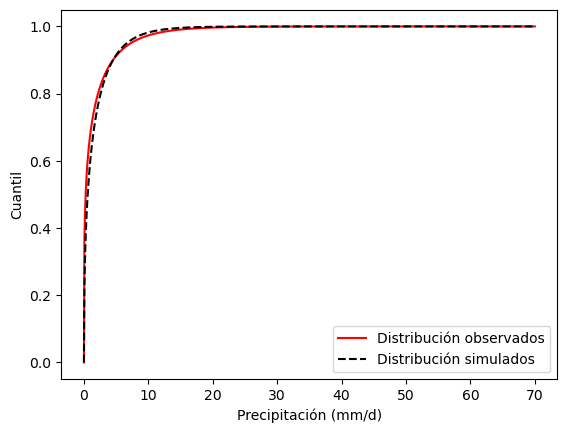

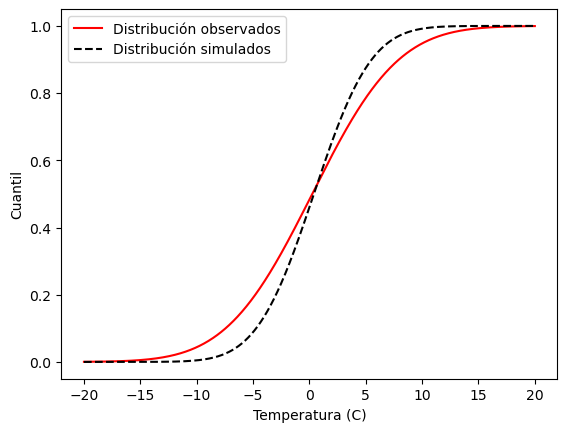

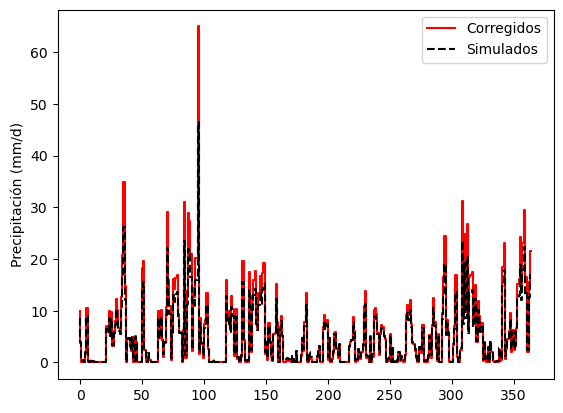

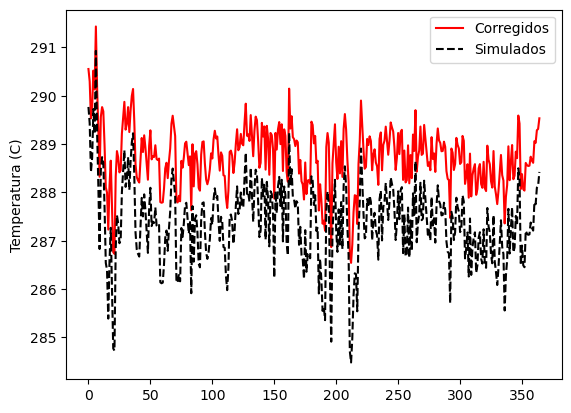

In [14]:
# Gráfica de los resultados
fig0 = plt.subplot()
v = np.linspace(0, 70, 1000)
fig0.plot(v, gamma_CFD(v, 0.25, 6), 'r-', label='Distribución observados')
fig0.plot(v, gamma_CFD(v, 0.4, 4), 'k--', label='Distribución simulados')
plt.xlabel('Precipitación (mm/d)')
plt.ylabel('Cuantil')
plt.legend()
plt.show()

fig1 = plt.subplot()
v = np.linspace(-20, 20, 1000)
fig1.plot(v, normal_CFD(v, 0.25, 6), 'r-', label='Distribución observados')
fig1.plot(v, normal_CFD(v, 0.4, 4), 'k--', label='Distribución simulados')
plt.xlabel('Temperatura (C)')
plt.ylabel('Cuantil')
plt.legend()
plt.show()

fig = plt.subplot()
fig.step(Pcorr['value'], 'r-', label = 'Corregidos')
fig.step(Psim['value'], 'k--', label= 'Simulados')
plt.ylabel('Precipitación (mm/d)')
fig.legend()
plt.show()

fig2 = plt.subplot()
fig2.plot(Tcorr['value'], 'r-', label = 'Corregidos')
fig2.plot(Tsim['value'], 'k--', label= 'Simulados')
plt.ylabel('Temperatura (C)')
fig2.legend()
plt.show()

**Parte 2 - Estimación de la evapotranspiración potencial mensual (25 puntos)**

El colega de su equipo de modelación que hizo la modelación climática regional, le hizo entrega de las siguientes series mensuales ya corregidas para el año 2050 en su área de estudio:

- Velocidad del viento: archivo *vel_viento2050.csv*
- Radiación neta: archivo *radiacion2050.csv*
- Humedad relativa: archivo *humedad2050.csv*

La velocidad del viento está en unidades de m/s, la radiación neta en MJ/m$^2$/d y la humedad relativa en %. Suponga que la velocidad del viento y la humedad relativa corresponden a una elevación de 2 m sobre la superficie. La presión atmosférica promedio a nivel de superficie en su área de estudio es 570 mb. 

Con esa información, el lider del equipo de modelación le pide estimar la evapotranspiración de referencia utilizando el método de Penman-Monteith de la FAO. Un colega le hace entrega además de los coeficientes de cultivo efectivos para cada mes con el fin de que estime la evapotranspiración potencial en el área de estudio. Dichos coeficientes están asignados a la variable tipo lista **kc**.

En el siguiente bloque se encuentran las funciones requeridas para hacer el cálculo de la $ET_0$. Así mismo, hay una función que toma una serie diaria y la transforma a una serie mensual.

In [15]:
def presion_vapor_sat(T):
    if (T>=0):
        es = 611 * np.exp(17.27*T/(T + 237.3))
    else:
        es = 611 * np.exp(21.87*T/(T + 265.5))
    return es

def latente(T):
    return 2.501 - 0.00236 * T

def delta(T):    
    D = 2508.3/((T + 237.3)**2) * np.exp(17.3*T/(T+237.3))
    return D

def psicrometrica(p, T, ca = 1e-3):
    lh = latente(T - 273.15)
    gamma = ca * p / (0.622 * lh)
    return gamma

def et0_fao(T, p, RH, Rn, u):
    D = delta(T - 273.15)
    gamma = psicrometrica(p, T)
    es = presion_vapor_sat(T - 273.15)/1000 # Presión de vapor de saturación (kPa)
    et0 = (0.408 * D * Rn + gamma * 900/T * u * es * (1 - RH/100)) / (D + gamma * (1 + 0.34 * u))
    return et0

def daily2monthly(ts, method='sum'):
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ts_m = []

    for m in months:
        temp = []

        for row in ts.iterrows():
            m_ = row[1][0].split(' ')[0]
            if m == m_:
                temp = temp + [row[1][1]]

        if method == 'sum':
            ret = sum(temp)
        elif method == 'mean':
            ret = np.mean(temp)

        ts_m = ts_m + [ret]
    
    return ts_m

Desarrolle en el siguiente bloque su código:

In [16]:
# Serie mensual de factores efectivos de cultivo
kc = [1, 0.5, 0.4, 0.8, 1.1, 1.2, 0.55, 0.25, 0.15, 0.4, 0.6, 1.2]

# Lista con número de días en cada mes
n = [31, 28.5, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

# ---- Convertir la serie diaria de temperatura a serie mensual --
T = daily2monthly(Tcorr, 'mean')
# ----------------------------------------------------------------

# Importar las series meteorológicas mensuales
RH = np.loadtxt('humedad2050.csv')
Rn = np.loadtxt('radiacion2050.csv')
u = np.loadtxt('vel_viento2050.csv')

p = 57 # Presión atmosférica (kPa)

# Calcular ET0 y PET para cada mes

# ---- ingrese aquí su código -------------------------------------
ET0 = PET = []
for T_i, RH_i, Rn_i, u_i, kc_i, n_i in zip(T, RH, Rn, u, kc, n):
    et0_i = et0_fao(T_i, p, RH_i, Rn_i, u_i)
    pet_i = kc_i * et0_i
    ET0 = ET0 + [et0_i * n_i]
    PET = PET + [pet_i * n_i]
# ----------------------------------------------------------------

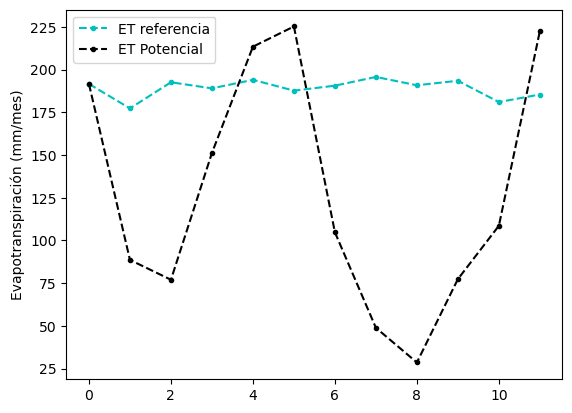

In [21]:
# Gráfica
plt.plot(ET0, 'c--.', label='ET referencia')
plt.plot(PET, 'k--.', label='ET Potencial')
plt.ylabel('Evapotranspiración (mm/mes)')
plt.legend()
plt.show()

**Parte 3 - Cálculo de la relación de mezcla cerca a la superficie (10 puntos)**

Un colega de su equipo planea utilizar un modelo físicamente basado de precipitación para evaluar los resultados del modelo climático regional y necesita para ello que usted le haga entrega de la serie mensual de la relación de mezcla cerca a la superficie en el año 2050 en su área de estudio. Grafique la serie de relación de mezcla obtenida en unidades de g/kg.

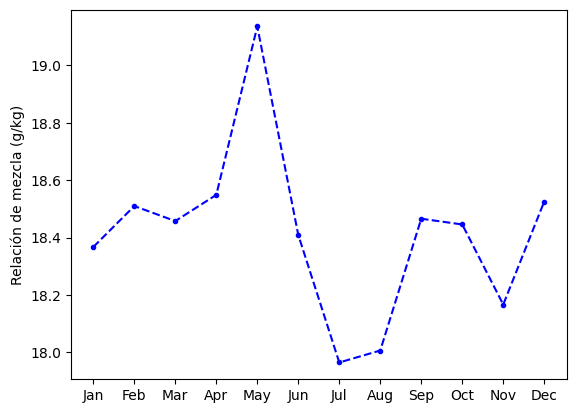

In [18]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# ---- ingrese aquí su código -----------------------------------
r = []
for RH_i, T_i in zip(RH, T):
    es = presion_vapor_sat(T_i - 273.15)
    e_i = RH_i/100 * es
    r_i = 0.622 * e_i/p
    r = r + [r_i]

plt.plot(months, r, 'b--.')
plt.ylabel('Relación de mezcla (g/kg)')
plt.show()
# ----------------------------------------------------------------

**Parte 4 - Cálculo de la recarga mensual de agua subterránea (40 puntos)**

Uno de sus compañeros está preparando un modelo hidrogeológico para su área de estudio y requiere valores mensuales promedio de recarga para el año 2050 con el fin de evaluar efectos de cambio climático sobre la disponibilidad de agua subterránea. 

Como una primera aproximación, su equipo de modelación cuenta con una relación empírica con la cual se pueden estimar valores mensuales multianuales de escorrentía en función de valores mensuales de precipitación y evapotranspiración potencial, dada por la siguiente expresión:

Si $P_m > PER_m$:

$$R_m = P_m[1-(PET_m/P_m)^{w}]$$

Si no:

$$R_m = 0$$

siendo $w=0.36$ en su área de estudio y $m$ el indicador del mes.

Escriba una función para calcular la escorrentía con la ecuación empírica presentada arriba y modifique el modelo de balance hídrico mensual tipo Thornthwaite para estimar los valores de recarga mensual de agua subterránea. La capacidad de almacenamiento máximo en el suelo $SM_{max}$ se estima en 113.6 mm.

**Nota:** Si obtiene valores negativos para la recarga, asigne un valor de 0 a dichos valores.

Finalmente, en una misma gráfica, presente las series de precipitación, PET, ET, humedad del suelo, escorrentía y recarga y describa brevemente los resultados.

En el siguiente bloque está el modelo de balance hídrico mensual.

In [34]:
# --- Genere la función para estimar la escorrentía aquí --------------
def runoff(P, PET, w):
    if P < PET:
        R = 0
    else:
        R = P * (1 - (PET/P) ** w)
    return R
# ---------------------------------------------------------------------

# ---- Convertir la serie diaria de precipitación a serie mensual -----
P = daily2monthly(Pcorr, 'sum')
# ---------------------------------------------------------------------

# --- Calcule la escorrentía mensual aquí -----------------------------
R = [runoff(P_i, PET_i, 0.36) for P_i, PET_i in zip(P, PET)]
# ---------------------------------------------------------------------

# --- Balance hídrico mensual (a modificar) ---------------------------
SMmax = 113.6
SM0 = 0
error = 1
tol = 1e-6

# Opción 1: Modificando el modelo conceptual:
while error > tol:
    SM_ini = SM0
    ET = SM = Q = []
    for PET_i, P_i in zip(PET, P):
        if PET_i <= P_i:
            ET_i = PET_i
            SM_i = min((P_i - ET_i) + SM_ini, SMmax)
            Q_i = max((P_i - ET_i) + SM_ini - SMmax, 0) # <-- Modificación 1   
        else:
            dSM = SM_ini * (1 - np.exp(-(PET_i - P_i)/SMmax))
            ET_i = P_i + dSM
            SM_i = SM_ini - dSM            
            Q_i = 0  # <-- Modificación 2
            
        SM_ini = SM_i
        
        ET = ET + [ET_i]
        SM = SM + [SM_i]
        Q = Q + [Q_i]
    
    error = abs(SM0 - SM_ini)
    SM0 = SM_ini
    
# Opción 2: Aplicando la ecuación de Balance Hídrico en forma discreta:
S0 = SM[-1]
dS = np.diff([S0] + SM)
Q = [P_i - ET_i - dS_i for P_i, ET_i, dS_i in zip(P,ET,dS)]
# ------------------------------------------------------------------------

# -- Calcule aquí la recarga ---------------------------------------------
G = [max(Q_i - R_i, 0) for Q_i, R_i in zip(Q, R)]
# ------------------------------------------------------------------------

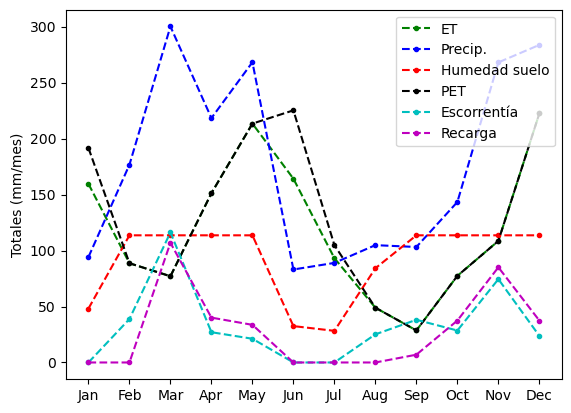

In [39]:
# -- Haga aquí la gráfica ------------------------------------------------
t = months
plt.plot(t, ET, 'g--.', label = 'ET')
plt.plot(t, P, 'b--.', label = 'Precip.')
plt.plot(t, SM, 'r--.', label = 'Humedad suelo')
plt.plot(t, PET, 'k--.', label = 'PET')
plt.plot(t, R, 'c--.', label = 'Escorrentía')
plt.plot(t, G, 'm--.', label = 'Recarga')

plt.ylabel('Totales (mm/mes)')
plt.legend(loc='upper right')
plt.show()
# ------------------------------------------------------------------------